In [158]:
#Cargando librerías 

from IPython.display import clear_output
import importlib

from PIL import Image
import matplotlib.pyplot as plt
import scipy as sp
#from scipy import ndimage as ndi
import numpy as np
import pandas as pd
import os
import sys  

root = os.getcwd() + "/.."

sys.path.insert(0, root)

import src.positioning_sensors as ps
importlib.reload(ps)

import src.regionGrowing as rg
importlib.reload(rg)

import src.manageExperiments as me
importlib.reload(me)

import config.config as cfg
importlib.reload(cfg)


from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.filters import rank

from skimage.draw import line


In [159]:
fn = "bratislava_experiment.txt"

In [160]:
me.createProject(fn)

Read File: ../experiments/bratislava_experiment.txt
Creating Directory in: ../experiments/bratislava_experiment/
Creating Directory ../experiments/bratislava_experiment/results/
Creating Directory: ../experiments/bratislava_experiment/semivariances/
Copy bratislava_experiment.txt -> ../experiments/bratislava_experiment/bratislava_experiment.txt


In [161]:
setup = me.readConfigFile(fn)

In [162]:
flat_means_decrease = bool(setup['flatness_means_decrease'])
print(flat_means_decrease)

True


In [163]:
#cargamos imagenes en luminance e importance

ilumina = cfg.data + setup["folder_input"] + setup["input_ntli"]
niveles = cfg.data + setup["folder_input"] + setup["input_evm"]

img = ilumina
im1 = np.array(Image.open(img))



In [164]:
#NTLI: luminance
NTLI = ps.readIMG(ilumina)

#EAM: Environtmental attention map is the importance
EAM = ps.readIMG(niveles, invert = True)

th = int(setup["desaturation_th"])

In [165]:
NTLI

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

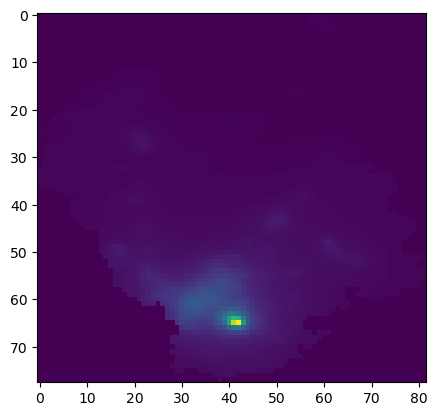

In [166]:
#standarize EAM
NTLI[np.isnan(NTLI)] = 0
plt.imshow(NTLI)

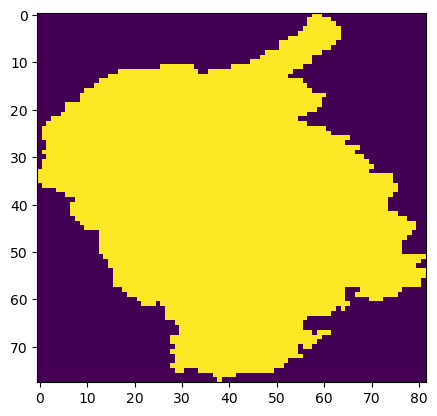

In [167]:
EAMBIN = (EAM==254)*1

EAM = np.copy(EAMBIN)
plt.imshow(EAM)

In [168]:
#DNTLI, distance = ps.desaturate(NTLI, th = th)

In [169]:
#smoothing parameters
sigma_y = setup['filterg_sy']
sigma_x =setup['filterg_sx']
sigma = [sigma_y, sigma_x]

FDNTLI = sp.ndimage.filters.gaussian_filter(NTLI, 
                                            sigma, 
                                            mode = setup['gaussian_mode'])


#we filter only the values greater than 22
#FDNTLI = (FDNTLI>=setup['neglect_values'])*FDNTLI

nonsatc = np.copy(FDNTLI)

#
#nonsatc[si] = 0
#plt.imshow(nonsatc)
#plt.show()

/var/folders/k9/wpfgnz550_n_k3t9tg8scnlw0000gn/T/ipykernel_39838/1300797728.py:6: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  FDNTLI = sp.ndimage.filters.gaussian_filter(NTLI,


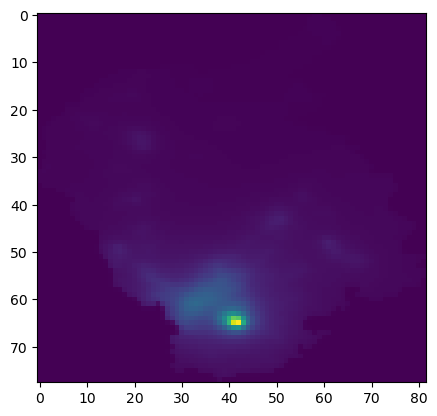

In [170]:
plt.imshow(nonsatc)

In [171]:
si = (60, 40)

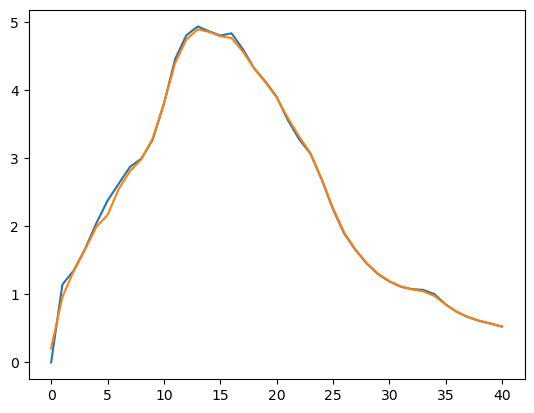

In [172]:
r = 20
#plt.plot(NTLI[si[0],si[1]-r:si[1]+r+1])
plt.plot(NTLI[si[0], si[1] - r:si[1] + r + 1])
plt.plot(FDNTLI[si[0], si[1] - r:si[1] + r + 1])
#plt.vlines(si[1],0,np.max(nonsat2[si[0],:]))


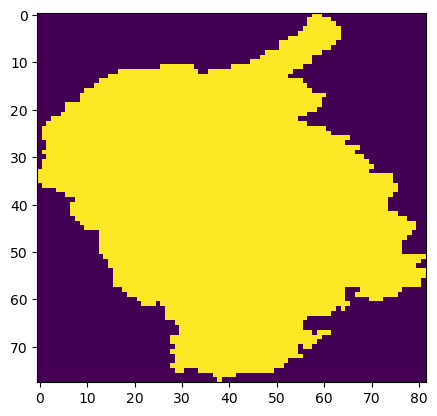

In [173]:
plt.imshow(EAM)

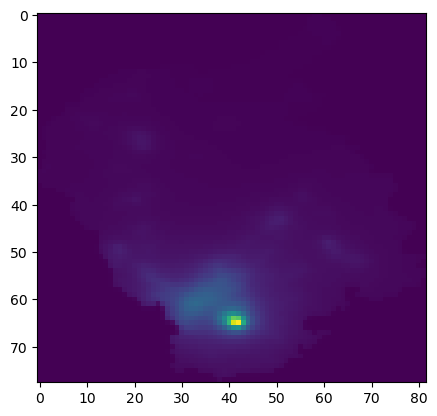

In [174]:
plt.imshow(FDNTLI)

In [175]:


coords = ps.get_coords(FDNTLI>0)

#fill the required params
#si = (28,19)

params = {"type": "semivar", 
          "atol": setup["tolerance_angle"], 
          "dtol": setup["tolerance_distance"]}


sv = np.zeros(FDNTLI.shape)

#tell to the class, which object is going to be used to make the semivariogram

rG = rg.rGrowing(FDNTLI)

rG.setParams(params)

n = len(coords)

#ncords x imagesize m x n
image_size = (n, FDNTLI.shape[0]*FDNTLI.shape[1])
allsemivariances = np.zeros(image_size)
allmask = np.zeros(image_size)


df = pd.DataFrame()



In [176]:
si = (60, 40)

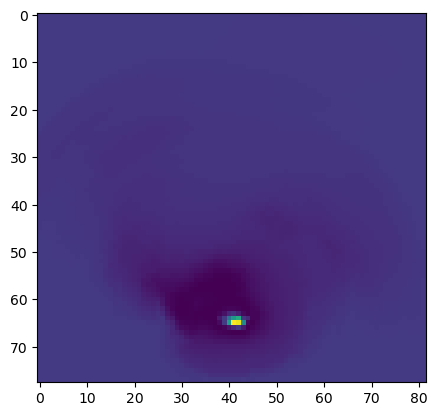

In [177]:
sv = rG.makeSemivarianceMap(si)
plt.imshow(sv)

In [178]:
si

(60, 40)

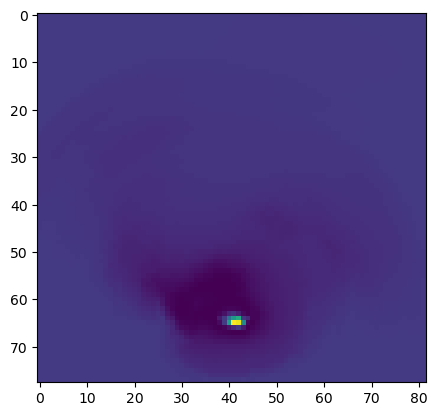

In [179]:
plt.imshow(sv)

In [180]:
len(coords)

4304

In [181]:
sv.shape[0]*sv.shape[1]

6396

In [ ]:
for i, si in enumerate(coords):
    print("coords:", si)
    
    clear_output(wait = True)
    s = "{percen: 1.2f}%"
    print(s.format(percen = 100*(i + 1)/n))
    
    si = tuple(si)

    #generate a semivariance sv map
    sv = rG.makeSemivarianceMap(si)
    
    #flattne sv to store it in a dataframe
    allsemivariances[i] = sv.flatten()
    
    #construct a mask of sv and then flatten it
    allmask[i] = ps.constructMask(si, sv, flat_means_decrease).flatten()

 0.42%
coords: [ 1 62]


In [114]:
svc = np.copy(sv)

In [115]:
svc[tuple(si)] = np.max(svc)

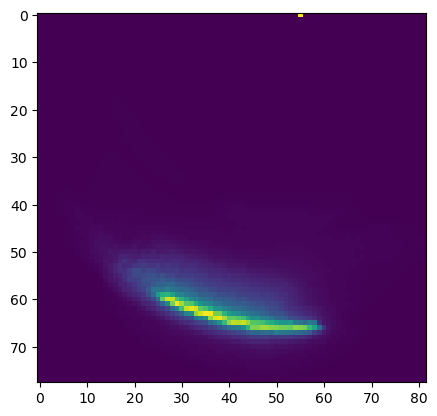

In [116]:
plt.imshow(svc)

In [117]:
ps.constructMask(si, sv, flat_means_decrease).flatten()

IndexError: index 78 is out of bounds for axis 0 with size 78

In [118]:
P = ps.perimeter(sv)

In [125]:
FDNTLI.shape

(78, 82)

In [126]:
sv.shape

(78, 82)

In [123]:
for pix in P:
    sv[pix]

IndexError: index 81 is out of bounds for axis 0 with size 78

In [127]:
pix

(81, 0)

In [128]:
np.shape(sv)

(78, 82)

In [23]:
#path to save collection of semivariances

prefix_path = (cfg.experiment + setup["experiment_id"] 
          + setup["folder_semivariances"] 
          + setup["output_semivariances"])


filesv = ( prefix_path + ".csv")

print("Semivariances saved at: ", filesv)

#filesvmask = (cfg.experiment + setup["experiment_id"] 
#              + setup["folder_semivariances"] 
#              + setup["output_semivariances"] 
#              + "mask.csv")


#path to save collection of masks
#each semivariance map is associated with a mask.
#mask defines the region of influence

filesvmask = (prefix_path + "mask.csv")

print("Semivariances mask saved to: ", filesvmask)

Semivariances saved at:  ../experiments/config_exp_15062022_redo_exp/semivariances/semivariance050512022.csv
Semivariances mask saved to:  ../experiments/config_exp_15062022_redo_exp/semivariances/semivariance050512022mask.csv


In [24]:


df_semivariance = pd.DataFrame(allsemivariances)
df_semivariance.insert(0, "coordsy", coords[:,0]) 
df_semivariance.insert(1, "coordsx", coords[:,1])
df_semivariance.to_csv(filesv)

df_semivariance_mask = pd.DataFrame(allmask)
df_semivariance_mask.insert(0, "coordsy", coords[:,0]) 
df_semivariance_mask.insert(1, "coordsx", coords[:,1])
df_semivariance_mask.to_csv(filesvmask)